<a href="https://colab.research.google.com/github/ysun155/Math140-PROJECT/blob/main/3bed_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

https://www.projectpro.io/article/how-to-build-arima-model-in-python/544

In [1]:
!pip install statsmodels==0.11.0
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.7 MB 3.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 5.4 MB/s 


In [2]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

In [3]:
# To get csv from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Import data
# df = pd.read_csv (r'1bed.csv', names = ['value'], header = 0)
# print (df)

filepath = '/content/drive/Shareddrives/Math140Project/coding/csv data for each type/3bed.csv'
df = pd.read_csv (filepath, names = ['value'], header = 0)
print (df)

           value
Dec, 2014   3066
Jan, 2015   3095
Feb, 2015   3124
Mar, 2015   3275
Apr, 2015   3360
...          ...
Dec, 2021   4450
Jan, 2022   4844
Feb, 2022   4343
Mar, 2022   4412
Apr, 2022   4750

[89 rows x 1 columns]


In [5]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 0.318593
p-value: 0.978182


Since P-value is greater than the significance level ( P> 0.05), let’s difference the series and see how the autocorrelation plot looks like.

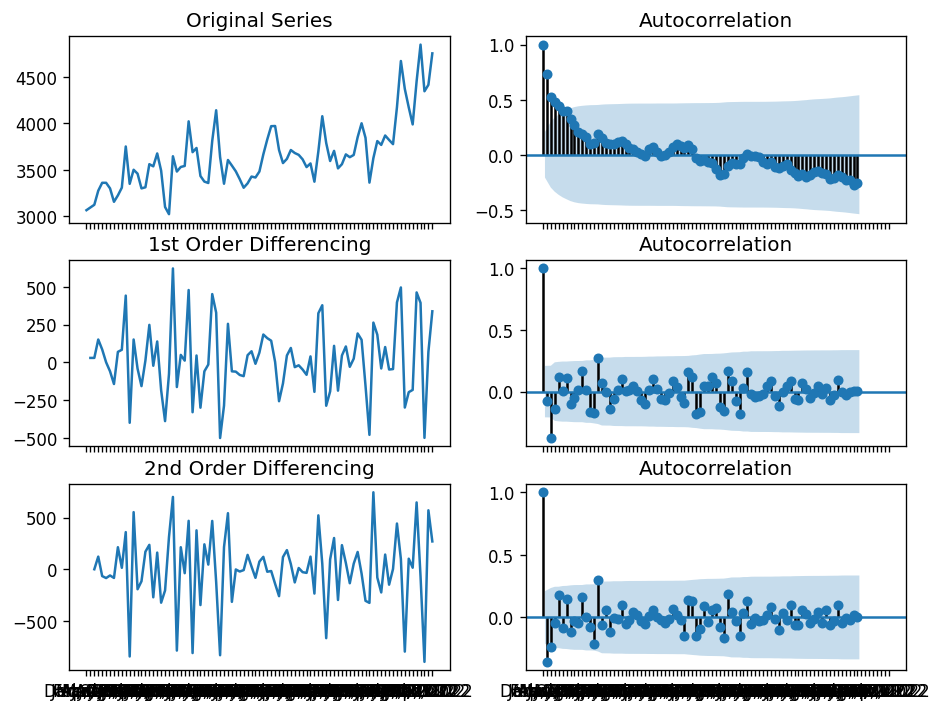

In [6]:
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1], lags=80)


# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1], lags=80)

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1], lags=80)

plt.show()

For the above series, the time series reaches stationarity with one orders of differencing. 
So, I am going to fix the order of differencing as 1.

In [7]:
from pmdarima.arima.utils import ndiffs
df = pd.read_csv(filepath, names=['value'], header=0)
y = df.value

## Adf Test
ndiffs(y, test='adf') 

# KPSS test
ndiffs(y, test='kpss')  

# PP test:
ndiffs(y, test='pp') 

0

find the order of the AR term (p)

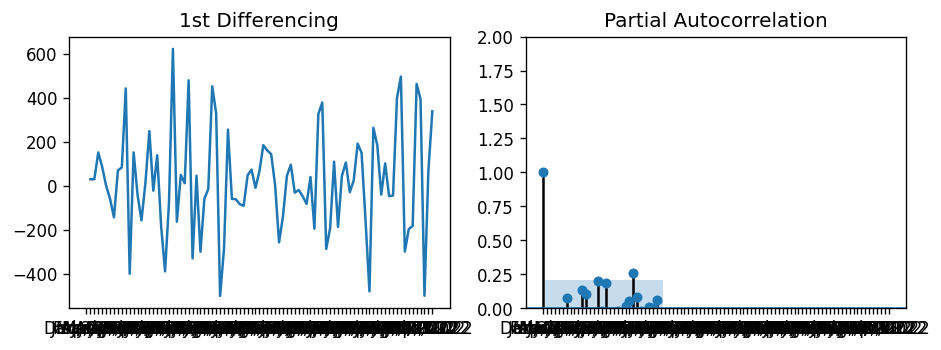

In [8]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,2))
plot_pacf(df.value.diff().dropna(), ax=axes[1], lags=30)

plt.show()

You can observe that the PACF lag 1 is quite significant. I am going to fix the p as 1.

find the order of the MA term (q)

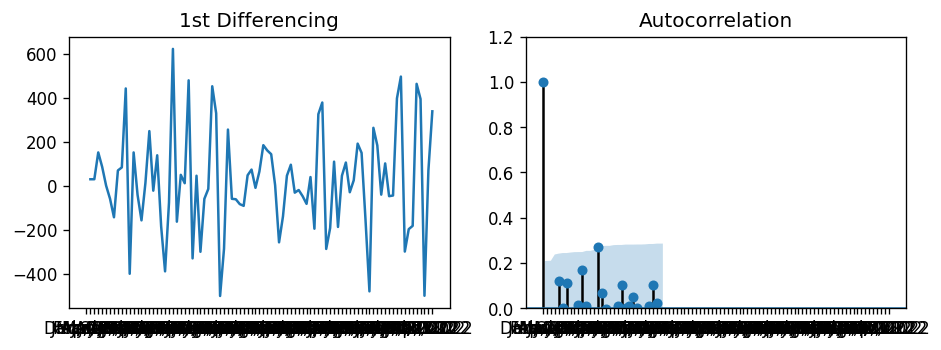

In [9]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})


fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.value.diff().dropna(), ax=axes[1], lags=30)

plt.show()

let’s tentatively fix q as 1.

 build the ARIMA Model

In [10]:
from statsmodels.tsa.arima_model import ARIMA

# ARIMA Model
model = ARIMA(df.value, order=(2,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   88
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -592.204
Method:                       css-mle   S.D. of innovations            201.657
Date:                Thu, 26 May 2022   AIC                           1194.408
Time:                        01:15:17   BIC                           1206.794
Sample:                    01-01-2015   HQIC                          1199.398
                         - 04-01-2022                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            16.1952      7.616      2.126      0.033       1.267      31.123
ar.L1.D.value     0.4117      0.145      2.843      0.004       0.128       0.695
ar.L2.D.value    -0.3452      0.111     

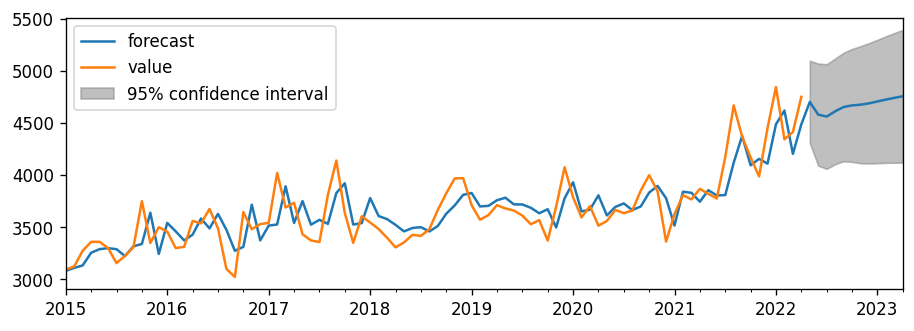

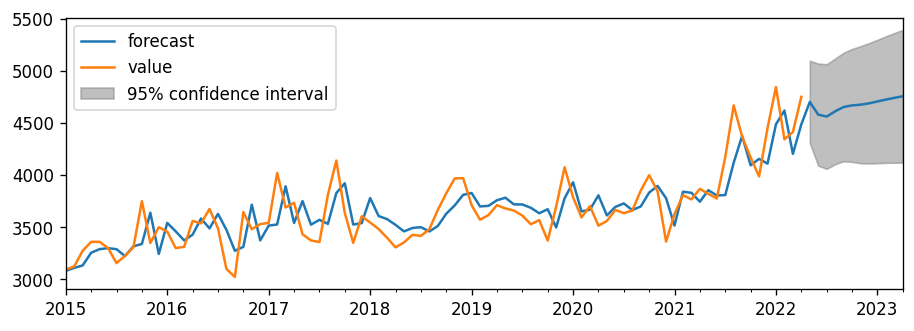

In [15]:
model_fit.plot_predict(1,100)

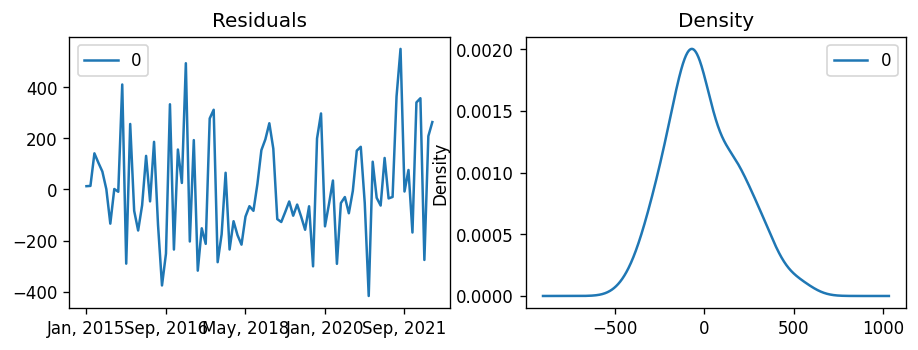

In [11]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:342: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


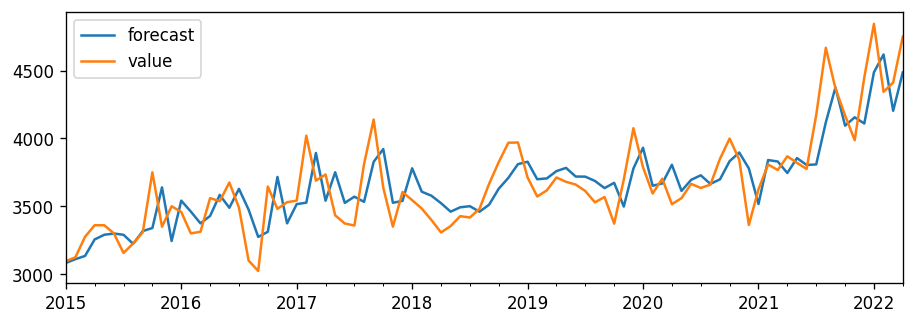

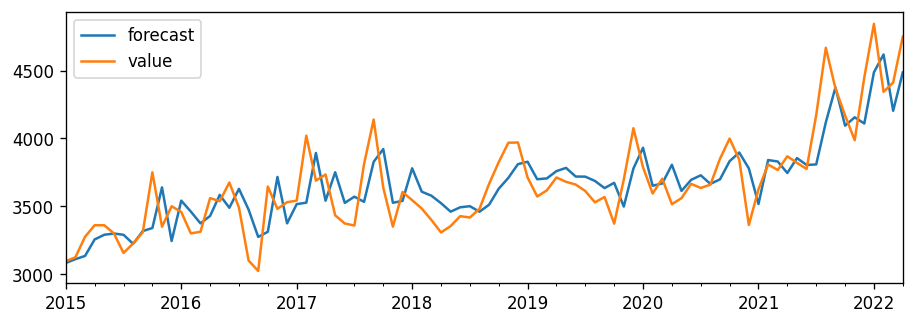

In [12]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)

[3659 3850 3999 3843 3362 3625 3808 3767 3868 3820 3775 4172 4668 4368
 4170 3987 4450 4844 4343 4412 4750]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


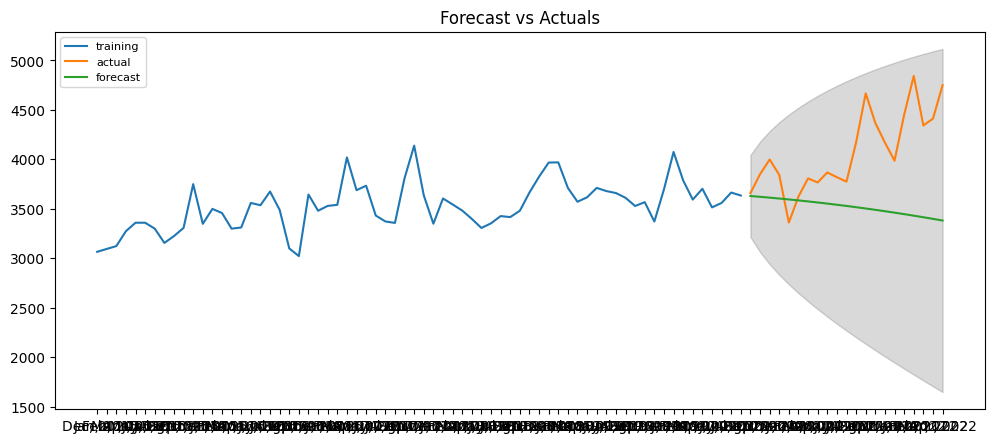

[3629.91570669 3621.80348656 3613.47530812 3604.64820289 3595.350646
 3585.579772   3575.33586925 3564.61890872 3553.42889333 3541.76582279
 3529.62969713 3517.02051635 3503.93828044 3490.38298941 3476.35464326
 3461.85324198 3446.87878559 3431.43127406 3415.51070742 3399.11708565
 3382.25040876] [211.52442543 284.48787775 343.42930359 393.53669831 437.95766507
 478.26965325 515.43854221 550.10172895 582.70655974 613.58125588
 642.97510116 671.08271037 698.05947307 724.03180319 749.10418264
 773.36414527 796.88589286 819.7329758  841.96031813 863.61577297
 884.74133489] [[3215.335451   4044.49596237]
 [3064.21749214 4179.38948099]
 [2940.36624185 4286.58437438]
 [2833.33044761 4375.96595816]
 [2736.9693957  4453.7318963 ]
 [2648.18847673 4522.97106728]
 [2565.09489027 4585.57684823]
 [2486.43933214 4642.79848529]
 [2411.34502268 4695.51276398]
 [2339.16865967 4744.36298591]
 [2269.42165591 4789.83773835]
 [2201.72257337 4832.31845933]
 [2135.76685416 4872.10970672]
 [2071.3067315  4909

In [16]:
#out-of-sample forecasting
# split into train and test sets
from statsmodels.tsa.api import ARIMA
size = len(df.value) - 21
train, test = df.value[0:size], df.value[size:]
print(np.array(test))
# fit an ARIMA model
model2 = ARIMA(train, order=(1,2,1))
model2_fit = model2.fit()
# forecast
fc, se, conf = model2_fit.forecast(steps=21, exog=None, alpha=0.05)
#output: forecast,standard error,confidence interval

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

print(fc, se, conf)

In [14]:
#predicted value
model_fit.forecast(steps=12, exog=None, alpha=0.05)
#output: forecast, standard error, confidence interval

(array([4701.06820953, 4579.35380954, 4561.25670007, 4610.94482412,
        4652.76753149, 4667.95047854, 4674.88146061, 4687.61207954,
        4705.57920176, 4723.6999265 , 4740.07607921, 4755.68097818]),
 array([201.65701152, 249.77614718, 255.85148294, 258.41386782,
        265.32782404, 276.16569187, 286.20252101, 294.36704216,
        301.84520685, 309.42897544, 317.10387872, 324.61106492]),
 array([[4305.82772973, 5096.30868934],
        [4089.80155688, 5068.9060622 ],
        [4059.79700812, 5062.71639202],
        [4104.46295008, 5117.42669815],
        [4132.73455227, 5172.80051071],
        [4126.67566872, 5209.22528836],
        [4113.93482714, 5235.82809408],
        [4110.66327866, 5264.56088042],
        [4113.97346742, 5297.1849361 ],
        [4117.23027887, 5330.16957412],
        [4118.56389755, 5361.58826086],
        [4119.45498196, 5391.90697441]]))